<a href="https://colab.research.google.com/github/NgPcAnhh/DiffiT/blob/main/DiffiT_Latent_space.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

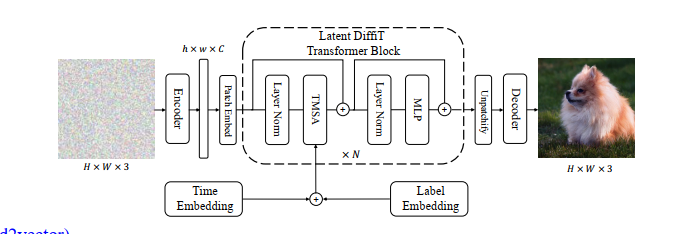

# tải và import thư viện

In [ ]:
!pip install torch torchvision tensorflow transformers diffusers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 47.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

#  Encoder

In [ ]:
# sử dụng mạng VAE (variational auto-encoder network)
# vì trong paper ghi thế

import torch
from diffusers import AutoencoderKL
from torchvision import transforms

# Tải VAE từ Stable Diffusion
vae = AutoencoderKL.from_pretrained("stabilityai/stable-diffusion-2-base", subfolder="vae")
vae.eval()  # Chuyển sang chế độ inference

# Đóng băng trọng số VAE
for param in vae.parameters():
    param.requires_grad = False

xử lý Encoder (sử dụng VAE) từ ảnh gốc thành latent image, sau đó chuyển đổi sang dạng vecto, bằng patch embedding

In [ ]:
import torch
import torch.nn as nn
from einops import rearrange

class Encoder(nn.Module):
    def __init__(self, vae, img_size=512, patch_size=16, in_channels=3, hidden_dim=768):
        super().__init__()
        self.vae = vae

        latent_channels = 4
        latent_size = img_size // 8  # 64x64 cho ảnh 512x512

        self.patch_size = patch_size
        self.latent_size = latent_size
        self.hidden_dim = hidden_dim

        # Kiểm tra latent_size chia hết cho patch_size
        assert latent_size % patch_size == 0, "latent_size phải chia hết cho patch_size"
        self.patches_per_side = latent_size // patch_size
        self.num_patches = self.patches_per_side ** 2

        self.patch_embedding = nn.Conv2d(
            in_channels=latent_channels,
            out_channels=hidden_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

        self.position_embedding = nn.Parameter(torch.zeros(1, self.num_patches, hidden_dim))

    def encode_to_latent(self, noisy_images):
        """Chuyển ảnh nhiễu thành latent space (đã điều chỉnh scaling factor)"""
        with torch.no_grad():
            # Đảm bảo ảnh có định dạng đúng [B,C,H,W]
            if noisy_images.ndim == 3:
                noisy_images = noisy_images.unsqueeze(0)

            latents = self.vae.encode(noisy_images).latent_dist.sample()
            latents = latents / self.vae.config.scaling_factor
        return latents

    def forward(self, noisy_images):
        # Chuẩn hóa ảnh về [-1, 1] nếu đầu vào là [0, 1]
        if noisy_images.max() <= 1.0:
            noisy_images = noisy_images * 2 - 1

        latents = self.encode_to_latent(noisy_images)  # [batch, 4, 64, 64]
        patches = self.patch_embedding(latents)        # [batch, hidden_dim, 4, 4]

        # Reshape và thêm positional embedding
        embedded = rearrange(patches, 'b c h w -> b (h w) c')
        embedded = embedded + self.position_embedding

        return embedded  # [batch, num_patches, hidden_dim]

# Latent DiffiT Block

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# hàm vecto hóa vị trí của time embedding:

"""
Nếu vị trí vecto là chẵn thì chọn sin(t):
  PE(t,2i)​=sin(t⋅10000−2i/d)
Nếu vị trí vecto là lẻ thì chọn cos(t)
  PE(t,2i+1)​=cos(t⋅10000−2i/d)
"""
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

# hàm swish = X * sigmoid(X)
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

#   Embedding thời gian với MLP và hàm kích hoạt Swish theo paper

class TimeEmbedding(nn.Module):
    def __init__(self, time_embed_dim, model_dim):
        super().__init__()
        self.time_embed_dim = time_embed_dim

        # MLP với hàm kích hoạt Swish theo paper
        self.time_embed = nn.Sequential(
            SinusoidalPositionEmbeddings(time_embed_dim),
            nn.Linear(time_embed_dim, model_dim),
            Swish(),
            nn.Linear(model_dim, model_dim)
        )

    def forward(self, time):
        return self.time_embed(time)

#    Embedding nhãn với MLP và hàm kích hoạt Swish
class LabelEmbedding(nn.Module):
    def __init__(self, num_classes, embed_dim, model_dim):
        super().__init__()
        self.embedding = nn.Embedding(num_classes, embed_dim)

        # MLP với hàm kích hoạt Swish
        self.projection = nn.Sequential(
            nn.Linear(embed_dim, model_dim),
            Swish(),
            nn.Linear(model_dim, model_dim)
        )

    def forward(self, labels):
        x = self.embedding(labels)
        return self.projection(x)


 Time-dependant Multihead Self-Attention (TMSA)

In [ ]:
class TimeDependentMultiHeadAttention(nn.Module):
    """
    Time-dependent Multi-head Self-Attention (TMSA) theo paper:
    Sử dụng công thức:
    qs = xs*Wqs + xt*Wqt
    ks = xs*Wks + xt*Wkt
    vs = xs*Wvs + xt*Wvt
    """
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.0):
        super().__init__()
        inner_dim = dim_head * heads

        self.heads = heads
        self.scale = dim_head ** -0.5
        self.attend = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)

        # Spatial projection weights (Wqs, Wks, Wvs)
        self.to_q_spatial = nn.Linear(dim, inner_dim, bias=False)
        self.to_k_spatial = nn.Linear(dim, inner_dim, bias=False)
        self.to_v_spatial = nn.Linear(dim, inner_dim, bias=False)

        # Temporal projection weights (Wqt, Wkt, Wvt)
        self.to_q_temporal = nn.Linear(dim, inner_dim, bias=False)
        self.to_k_temporal = nn.Linear(dim, inner_dim, bias=False)
        self.to_v_temporal = nn.Linear(dim, inner_dim, bias=False)

        # Output projection
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

        # Relative position bias
        self.rel_pos_bias = nn.Parameter(torch.zeros(heads, 49, 49))  # Relative position bias (B trong paper)

    def forward(self, x, time_emb):
        """
        x: [batch_size, seq_len, dim] - Spatial embeddings (xs)
        time_emb: [batch_size, dim] - Time token (xt)
        """
        batch_size, seq_len, _ = x.shape
        h = self.heads

        # 1. Tính phần spatial của queries, keys, values (xs*Wqs, xs*Wks, xs*Wvs)
        q_spatial = self.to_q_spatial(x).reshape(batch_size, seq_len, h, -1).permute(0, 2, 1, 3)  # [b, h, seq, d_head]
        k_spatial = self.to_k_spatial(x).reshape(batch_size, seq_len, h, -1).permute(0, 2, 1, 3)  # [b, h, seq, d_head]
        v_spatial = self.to_v_spatial(x).reshape(batch_size, seq_len, h, -1).permute(0, 2, 1, 3)  # [b, h, seq, d_head]

        # 2. Tính phần temporal của queries, keys, values (xt*Wqt, xt*Wkt, xt*Wvt)
        time_emb_expanded = time_emb.unsqueeze(1)  # [batch_size, 1, dim]
        q_temporal = self.to_q_temporal(time_emb_expanded).reshape(batch_size, 1, h, -1).permute(0, 2, 1, 3)  # [b, h, 1, d_head]
        k_temporal = self.to_k_temporal(time_emb_expanded).reshape(batch_size, 1, h, -1).permute(0, 2, 1, 3)  # [b, h, 1, d_head]
        v_temporal = self.to_v_temporal(time_emb_expanded).reshape(batch_size, 1, h, -1).permute(0, 2, 1, 3)  # [b, h, 1, d_head]

        # 3. Tính tổng theo công thức trong paper (qs = xs*Wqs + xt*Wqt)
        # Broadcast q_temporal, k_temporal, v_temporal để cộng với mỗi token trong chuỗi
        q_temporal = q_temporal.expand(-1, -1, seq_len, -1)
        k_temporal = k_temporal.expand(-1, -1, seq_len, -1)
        v_temporal = v_temporal.expand(-1, -1, seq_len, -1)

        q = q_spatial + q_temporal  # qs = xs*Wqs + xt*Wqt
        k = k_spatial + k_temporal  # ks = xs*Wks + xt*Wkt
        v = v_spatial + v_temporal  # vs = xs*Wvs + xt*Wvt

        # 4. Tính attention với relative position bias (B)
        # Softmax((QK^T)/sqrt(d) + B)V theo công thức (6) trong paper
        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale  # QK^T/sqrt(d)

        # Thêm relative position bias
        if seq_len <= 64:  # theo research căn 64 trả ra kết quả ok hơn //03/30/2025//
            bias = self.rel_pos_bias[:, :seq_len, :seq_len]
            dots = dots + bias.unsqueeze(0)  # Thêm bias vào attention scores

        attn = self.attend(dots)  # Softmax
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)  # Nhân với values
        out = out.permute(0, 2, 1, 3).reshape(batch_size, seq_len, -1)

        return self.to_out(out)

MLP: multi layers perceptron == feed-forward

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.0):
        super().__init__()
        # MLP cho spatial features
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            Swish(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

        # MLP cho time conditioning
        self.time_mlp = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, dim)
        )

    def forward(self, x, time_emb):
        # Tạo time conditioning
        time_out = self.time_mlp(time_emb).unsqueeze(1)  # [batch_size, 1, dim]

        # Áp dụng gated mechanism
        return self.net(x) + time_out  # Additive conditioning

class LatentDiffiTTransformerBlock(nn.Module):
    def __init__(
        self,
        dim,
        heads=8,
        dim_head=64,
        mlp_dim=None,
        dropout=0.0
    ):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = TimeDependentMultiHeadAttention(dim, heads=heads, dim_head=dim_head, dropout=dropout)
        self.norm2 = nn.LayerNorm(dim)

        mlp_dim = mlp_dim or (dim * 4)
        self.mlp = FeedForward(dim, mlp_dim, dropout=dropout)

    def forward(self, x, time_emb):
        # LayerNorm và TMSA với residual connection
        x = x + self.attn(self.norm1(x), time_emb)

        # LayerNorm và MLP với residual connection
        x = x + self.mlp(self.norm2(x), time_emb)

        return x

latent DiffiT transformer block

In [ ]:
class LatentDiffiTTransformer(nn.Module):
    def __init__(
        self,
        dim,
        depth,
        heads=8,
        dim_head=64,
        mlp_dim=None,
        dropout=0.0,
        time_embed_dim=None,
        label_embed_dim=None,
        num_classes=1000
    ):
        super().__init__()

        # Thông số
        self.dim = dim
        time_embed_dim = time_embed_dim or dim * 4
        label_embed_dim = label_embed_dim or dim

        # Time và Label Embedding với MLP và Swish activation
        self.time_embedding = TimeEmbedding(time_embed_dim, dim)
        self.label_embedding = LabelEmbedding(num_classes, label_embed_dim, dim)

        # Transformer blocks
        self.transformer_blocks = nn.ModuleList([
            LatentDiffiTTransformerBlock(
                dim=dim,
                heads=heads,
                dim_head=dim_head,
                mlp_dim=mlp_dim,
                dropout=dropout
            ) for _ in range(depth)
        ])

        # Final layer norm
        self.final_norm = nn.LayerNorm(dim)

    def combine_embeddings(self, time_emb, label_emb=None):
        # Kết hợp time embedding và label embedding (nếu có)
        if label_emb is not None:
            combined_emb = time_emb + label_emb
        else:
            combined_emb = time_emb
        return combined_emb

    def forward(self, x, time, labels=None):
        # Tạo time token từ timestep
        time_emb = self.time_embedding(time)

        # Tạo và kết hợp với label embedding nếu có
        if labels is not None:
            label_emb = self.label_embedding(labels)
            combined_emb = self.combine_embeddings(time_emb, label_emb)
        else:
            combined_emb = time_emb

        # Đi qua từng transformer block, time token được truyền qua mỗi block
        for block in self.transformer_blocks:
            x = block(x, combined_emb)

        # Final layer norm
        x = self.final_norm(x)

        return x

# Decoder

In [ ]:
import torch.nn as nn
from einops import rearrange

class Unpatchify(nn.Module):
    """Chuyển chuỗi token trở lại latent space"""
    def __init__(self, latent_size=64, patch_size=16, latent_channels=4, hidden_dim=768):
        super().__init__()
        self.latent_size = latent_size
        self.patch_size = patch_size
        self.latent_channels = latent_channels
        self.hidden_dim = hidden_dim

        # Tính toán số patch trên mỗi chiều
        self.patches_per_side = latent_size // patch_size

        # Lớp Conv Transpose để khôi phục latent space
        self.unpatchify = nn.ConvTranspose2d(
            in_channels=hidden_dim,
            out_channels=latent_channels,
            kernel_size=patch_size,
            stride=patch_size
        )

    def forward(self, x):
        """
        Args:
            x: Tensor shape [batch, num_patches, hidden_dim]
        Returns:
            latent: Tensor shape [batch, latent_channels, latent_size, latent_size]
        """
        # Reshape về [batch, hidden_dim, patches_per_side, patches_per_side]
        x = rearrange(x, "b (h w) c -> b c h w", h=self.patches_per_side)

        # Khôi phục latent space bằng ConvTranspose
        latent = self.unpatchify(x)  # [batch, latent_channels, latent_size, latent_size]
        return latent

In [ ]:
class LatentDiffiTDecoder(nn.Module):
    """Decoder sử dụng VAE từ Latent Diffusion Model"""
    def __init__(self, vae):
        super().__init__()
        self.vae = vae

    def forward(self, latent):
        """
        Args:
            latent: Tensor shape [batch, 4, 64, 64] (latent space đã xử lý)
        Returns:
            image: Tensor shape [batch, 3, 512, 512]
        """
        # Áp dụng scaling factor ngược lại (nếu cần)
        latent = latent * self.vae.config.scaling_factor

        # Giải mã latent thành ảnh
        with torch.no_grad():
            image = self.vae.decode(latent).sample

        # Chuẩn hóa ảnh về [0, 1] (Stable Diffusion VAE output [-1, 1])
        image = (image + 1) / 2
        return image

In [ ]:
class FinalDecoder(nn.Module):
    """Lớp tuyến tính để giải mã latent space → ảnh"""
    def __init__(self, latent_dim, output_channels=3):
        super().__init__()
        self.linear = nn.Linear(latent_dim, output_channels * 512 * 512)  # Ví dụ cho ảnh 512x512
        self.output_channels = output_channels

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.linear(x)  # [batch, 3*512*512]
        x = x.view(batch_size, self.output_channels, 512, 512)  # [batch, 3, 512, 512]
        return x

In [ ]:
import torch.nn as nn

class LatentDiffiT(nn.Module):
    def __init__(
        self,
        vae,
        hidden_dim=768,
        num_layers=12,
        num_heads=16,
        mlp_ratio=4,
        num_classes=1000,
        dropout=0.1,
        guidance_scale=7.5
    ):
        super().__init__()
        self.encoder = Encoder(vae, hidden_dim=hidden_dim)
        self.transformer = LatentDiffiTModel(...)
        self.unpatchify = Unpatchify(...)
        self.decoder = FinalDecoder(hidden_dim)
        self.guidance_scale = guidance_scale

    def forward(self, noisy_images, timesteps, labels=None):
        # Encoder
        tokens = self.encoder(noisy_images)

        # Classifier-Free Guidance
        if labels is not None:
            tokens_cond = self.transformer(tokens, timesteps, labels)
            tokens_uncond = self.transformer(tokens, timesteps)
            tokens = tokens_uncond + self.guidance_scale * (tokens_cond - tokens_uncond)
        else:
            tokens = self.transformer(tokens, timesteps)

        # Unpatchify
        latent = self.unpatchify(tokens)

        # Final Linear Decoder
        output = self.decoder(latent)
        return output

Patches shape: torch.Size([1, 16, 768])
